# Classification of rock images using deep learning

### by Johannes Leitner

### Highlights

* Images of three rock types (dolomite, limestone and cellular dolomite) are classified using a neural network. 
* 450 unique images (one for each rock) were taken by me using a mobile phone and a tripod. Each rock was labelled by a geologist. The classes are inbalanced. 
* In a five-fold cross validation the classification accuracy is 98% and the Matthews correlation coefficient equals 97%. 
* The effect of Mixup as an additional augmentation method is illustrated. In this case, it hurts classification performance. 


In [38]:
import fastai
from pathlib import Path
from tqdm import tqdm
from fastai.data.external import *
from fastai.vision.all import *
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

The experiments below are run on a machine where the GPU is deactivated on purpose by the following code: 

In [2]:
import torch
torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The original photographs were modified by the following code in order to reduce the irrelevant space around the rocks. This code is not run here. 

Show one example image of dolomite as it is used as an input for the model (before any augmentations). 

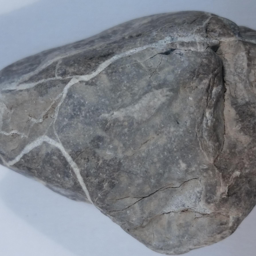

In [3]:
example = './Photos_cropped/Dolomite/Dolomite_Punkt6_2014_dark/20200904_142729.jpg'
im = Image.open(example)
im.to_thumb(256,256)

The rock types are dolomite (German: Dolomit), limestone (German: Kalkstein) and cellular dolomite (German: Rauwacke).

The classes are inbalanced as there are 
* 198 unique dolomite rock samples
* 202 unique limestone samples
* 52 unique cellular dolomite samples

In [4]:
rock_types = 'Dolomite','Limestone','CellularDolomite'
path_raw_data = Path('./Photos_cropped/')

In [5]:
fns = get_image_files(path_raw_data, folders = ['Dolomite','Limestone','CellularDolomite'])

In [6]:
def label_func(fname):
    return re.findall(r'[^_]*', parent_label(fname))[0]

In [7]:
rocks = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=label_func, 
    item_tfms=Resize(512),
    batch_tfms=aug_transforms(mult=2,min_zoom = 1.0,max_zoom = 2.5))

In [8]:
dls = rocks.dataloaders(path_raw_data)

The figure below illustrates data augmentations (rotations, cropping, zooming) that are applied by the fastai image preprocessing pipeline. All images show modifications of the same rock sample (dolomite). 

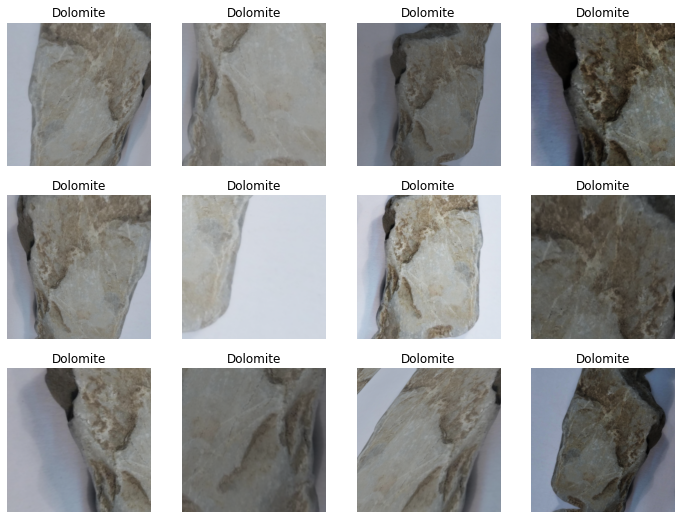

In [11]:
dls.train.show_batch(max_n=12, nrows=3, unique=True)

These are original (i.e. not augmented) images of 32 distinct rock samples from the validation data. Note that the sizes, shapes and colors are varying within the three classes. 

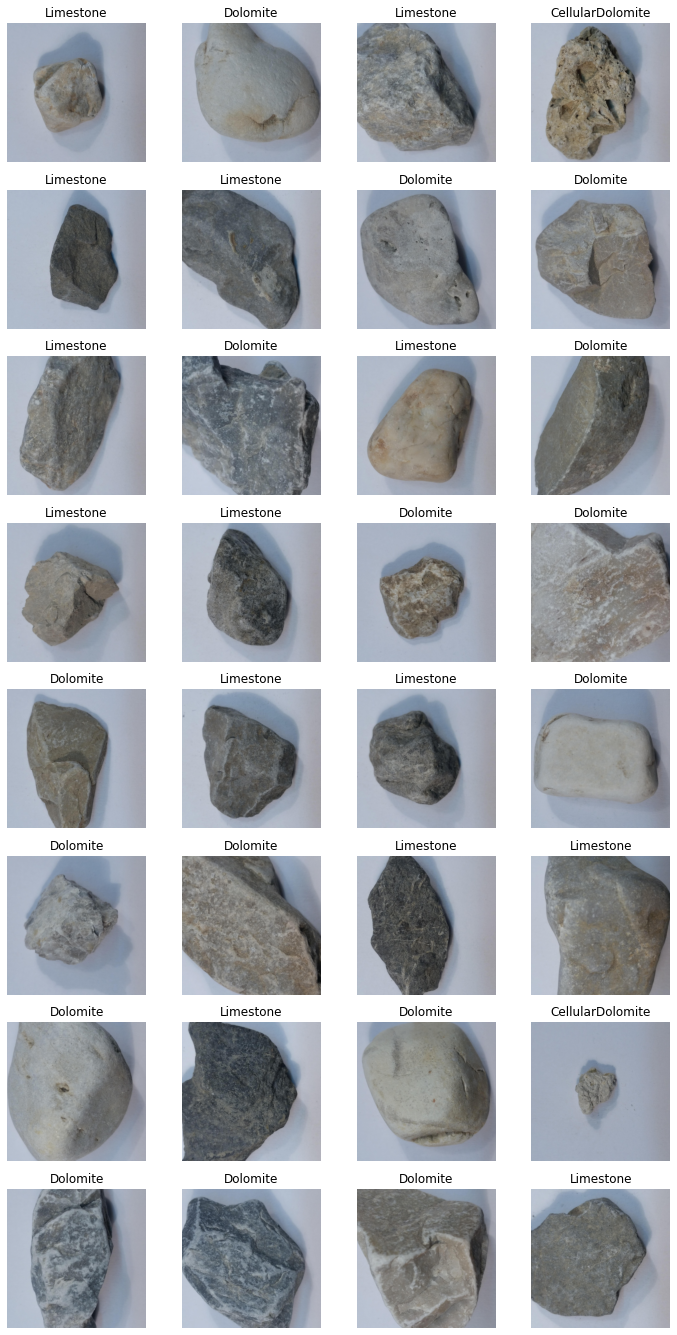

In [12]:
dls.valid.show_batch(max_n=32, nrows=8)

Note that the rock samples have a large variation within the same class. A folder of the raw data contains samples of similar rocks of the same class. The figures below show the differences/similarities between limestone samples in the data. 

In [37]:
def showImagesHorizontally(list_of_files):
    fig = figure(figsize=(15, 2))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image, aspect='equal')
        axis('off')

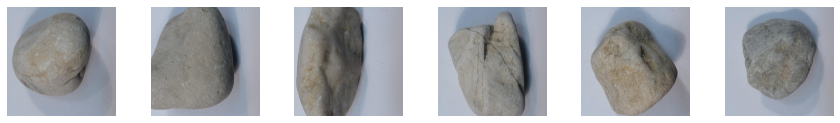

In [47]:
path_raw_data_limestone = Path('./Photos_cropped/Limestone/Limestone_Punkt6_2014_light/')
showImagesHorizontally([x for x in get_image_files(path_raw_data_limestone)])

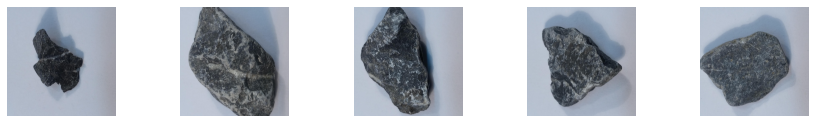

In [44]:
path_raw_data_limestone = Path('./Photos_cropped/Limestone/Limestone_Punkt49_2014_dark/')
showImagesHorizontally([x for x in get_image_files(path_raw_data_limestone)])

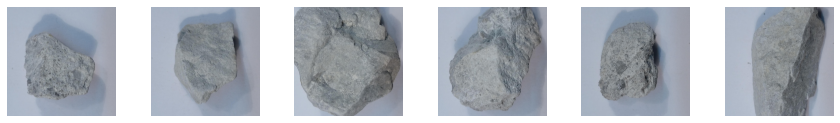

In [45]:
path_raw_data_limestone = Path('./Photos_cropped/Limestone/Limestone_Punkt17_2012_light/')
showImagesHorizontally([x for x in get_image_files(path_raw_data_limestone)])

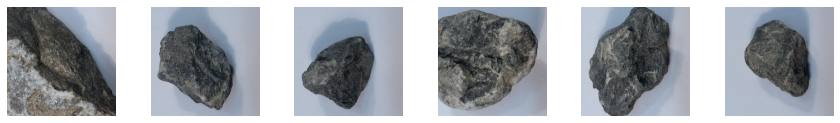

In [46]:
path_raw_data_limestone = Path('./Photos_cropped/Limestone/Limestone_Punkt136_2015_dark3/')
showImagesHorizontally([x for x in get_image_files(path_raw_data_limestone)])

# 5 fold cross validation 

Create train and validation indices for 5 different cross validation runs. In order to emphasize this point: 
This means that each of the 450 rock samples is either in the validation dataset or in the training dataset. There is only one single image of a rock. It is not the case that images of the same rock are in both train and test.

In [12]:
import random
CV = 5
all_indices = [i for i in range(len(fns))]
random.seed(4)
random.shuffle(all_indices)
n = int(len(all_indices)/CV)
validation_cv_indices = [all_indices[i:i + n] for i in range(0, len(all_indices), n)]
train_cv_indices = [list(set(all_indices) - set(validation_cv_indices[i])) for i in range(CV)]

Find the optimal learning rate using the first cross validation split

In [13]:
def splitter(fns):
    return train_cv_indices[0],validation_cv_indices[0]

rocks_LR = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter= splitter,
    get_y=label_func, 
    item_tfms=Resize(512),
    batch_tfms=aug_transforms(mult=2,min_zoom = 1.0,max_zoom = 1.2))

dls_LR = rocks_LR.dataloaders(path_raw_data)

In [14]:
learn_LR = cnn_learner(dls_LR, resnet34, metrics=accuracy)

SuggestedLRs(valley=0.0006918309954926372)

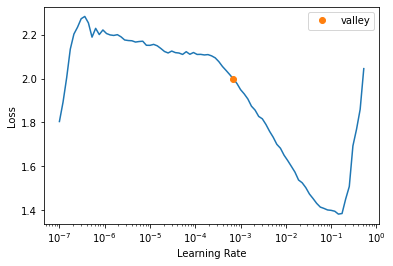

In [15]:
learn_LR.lr_find()

Cross validation over 5 each with 3 different values of mixup

In [73]:
model = xresnet34()
EPOCHS = 150
FREEZE_EPOCHS = 5
LEARNING_RATE = 10e-3

mixup_values = [0,0.25,0.5]

result_list = []

for cv in range(CV):
    def splitter(fns):
        return train_cv_indices[cv],validation_cv_indices[cv]

    rocks_CV = DataBlock(
        blocks = (ImageBlock, CategoryBlock), 
        get_items = get_image_files, 
        splitter = splitter,
        get_y = label_func, 
        item_tfms = Resize(512),
        batch_tfms = aug_transforms(mult = 2,min_zoom = 1.0,max_zoom = 1.2))

    dls_CV = rocks_CV.dataloaders(path_raw_data)     
    
    for mix_up in mixup_values:
        if mix_up > 0:
            mixup = MixUp(mix_up)
            learn_cv = Learner(dls_CV, model, metrics = (accuracy, MatthewsCorrCoef(),BalancedAccuracy()), 
                                     cbs = mixup,loss_func = CrossEntropyLossFlat())
            learn_cv.fine_tune(epochs = EPOCHS, freeze_epochs = FREEZE_EPOCHS,base_lr = LEARNING_RATE)
            learn_cv.remove_cbs([MixUp])
        else: 
            learn_cv = Learner(dls_CV, model, metrics = (accuracy, MatthewsCorrCoef(),BalancedAccuracy()), 
                                     loss_func = CrossEntropyLossFlat())
            learn_cv.fine_tune(epochs = EPOCHS, freeze_epochs = FREEZE_EPOCHS,base_lr = LEARNING_RATE)            
            
        _, _, actuals, preds = learn_cv.get_preds(with_input=True, with_decoded=True)
        actuals = pd.DataFrame(actuals)
        preds = pd.DataFrame(preds)
        result = pd.concat([actuals, preds], axis = 1)
        result.columns = ['actuals', 'predictions']
        result['CV'] = cv
        result['Mixup'] = mix_up
        result_list.append(result)    
    
df_results = pd.concat(result_list)

epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,6.801190,6.469944,0.400000,0.039077,0.333333,02:16
1,5.305773,4.009023,0.377778,-0.093098,0.311448,02:07
2,3.860592,1.768379,0.488889,0.000000,0.333333,02:08
3,3.021367,1.248982,0.388889,-0.011675,0.342424,02:03
4,2.527108,1.035922,0.566667,0.276745,0.440236,02:07


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.814936,1.262087,0.422222,0.102599,0.400000,02:05
1,0.793240,0.898641,0.577778,0.234948,0.429293,02:11
2,0.767992,0.934506,0.555556,0.188866,0.400673,02:10
3,0.750568,0.791829,0.633333,0.344731,0.520370,02:07
4,0.743715,0.761110,0.655556,0.404562,0.573064,02:03
5,0.727696,0.950762,0.555556,0.233810,0.440404,02:10
6,0.721694,1.285688,0.500000,0.158384,0.437879,02:08
7,0.703917,1.109775,0.511111,0.194272,0.472896,02:13
8,0.693760,0.727471,0.611111,0.362522,0.544444,02:09
9,0.688927,1.814361,0.477778,0.235178,0.436195,02:01


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.510715,0.578215,0.744444,0.593302,0.742256,01:57
1,0.506280,0.801170,0.677778,0.454888,0.639731,01:57
2,0.555144,0.807656,0.700000,0.530776,0.706902,01:57
3,0.578685,1.851576,0.466667,0.056425,0.355219,01:56
4,0.593968,2.594797,0.488889,0.015213,0.333333,01:56


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.578676,2.031120,0.588889,0.285849,0.491751,01:56
1,0.553120,0.464597,0.800000,0.656099,0.769529,01:56
2,0.526574,0.665686,0.755556,0.594309,0.622222,01:57
3,0.514142,0.532679,0.800000,0.652167,0.652525,01:57
4,0.506069,0.757434,0.711111,0.532858,0.717845,01:56
5,0.500045,0.980789,0.588889,0.356110,0.538721,01:56
6,0.485527,0.514352,0.722222,0.584695,0.720370,01:56
7,0.474620,0.509915,0.777778,0.611283,0.654714,01:57
8,0.467861,0.390091,0.855556,0.783729,0.875758,01:57
9,0.463859,0.745246,0.677778,0.547363,0.651515,01:57


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.446166,0.343602,0.866667,0.771567,0.847475,01:57
1,0.482974,0.539924,0.777778,0.629004,0.690572,01:57
2,0.521750,1.572719,0.566667,0.370531,0.647306,01:57
3,0.522546,3.895051,0.400000,0.000000,0.333333,01:57
4,0.536195,0.571739,0.733333,0.552635,0.768855,01:56


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.525302,0.325538,0.911111,0.861831,0.939394,01:56
1,0.538531,0.464753,0.766667,0.625903,0.734512,01:56
2,0.531810,0.212614,0.944444,0.908063,0.936364,01:56
3,0.507835,0.840011,0.666667,0.489898,0.703199,01:56
4,0.498046,0.523483,0.755556,0.636823,0.772222,01:56
5,0.497870,1.103277,0.577778,0.295701,0.457239,01:56
6,0.500690,0.483514,0.733333,0.536274,0.643434,01:57
7,0.491778,0.314957,0.877778,0.803022,0.889226,01:56
8,0.485688,0.252129,0.900000,0.833124,0.902694,01:56
9,0.479725,0.257486,0.911111,0.849932,0.910269,01:56


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.152910,0.170908,0.966667,0.949491,0.975000,01:57
1,0.143210,0.463897,0.844444,0.756639,0.852546,01:56
2,0.142795,1.938872,0.500000,0.391087,0.614583,01:56
3,0.146245,2.590279,0.611111,0.493435,0.611111,01:56
4,0.175607,3.143721,0.566667,0.404716,0.528935,01:55


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.230732,1.333285,0.622222,0.487357,0.605324,01:56
1,0.185984,0.924045,0.700000,0.597938,0.718750,01:56
2,0.179987,0.121764,0.955556,0.932453,0.958333,01:56
3,0.182073,0.441756,0.822222,0.755617,0.836111,01:56
4,0.177486,0.396140,0.855556,0.796041,0.861111,01:56
5,0.168418,0.570265,0.811111,0.745454,0.837963,01:56
6,0.165617,1.258608,0.700000,0.625920,0.764815,01:57
7,0.158226,0.586079,0.766667,0.681021,0.820833,01:56
8,0.150629,0.108619,0.977778,0.965062,0.981250,01:56
9,0.148231,0.216557,0.900000,0.856316,0.914815,01:56


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.455494,0.238379,0.966667,0.947563,0.962731,01:56
1,0.474690,0.527812,0.877778,0.811456,0.855093,01:57
2,0.476680,1.238048,0.466667,0.186144,0.442593,01:56
3,0.478590,0.629319,0.744444,0.602029,0.744907,01:56
4,0.496198,4.237618,0.477778,0.218302,0.467593,01:57


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.503107,0.768223,0.622222,0.534324,0.665741,01:56
1,0.464560,0.887617,0.666667,0.529220,0.692824,01:57
2,0.449531,0.191478,0.933333,0.897046,0.927546,01:56
3,0.423940,1.040962,0.566667,0.480496,0.670833,01:55
4,0.413231,0.838362,0.633333,0.533618,0.710648,01:57
5,0.405707,0.321339,0.866667,0.811893,0.879630,01:57
6,0.393913,0.894753,0.622222,0.520167,0.673843,01:56
7,0.387286,0.331126,0.866667,0.795724,0.865278,01:57
8,0.375702,0.619338,0.688889,0.599359,0.744213,01:56
9,0.370768,0.538590,0.755556,0.683488,0.806481,01:56


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.414830,0.260626,0.922222,0.881196,0.929398,02:53
1,0.396062,2.007169,0.500000,0.267603,0.425926,02:56
2,0.396919,0.835353,0.700000,0.587065,0.678241,02:51
3,0.427337,0.244147,0.922222,0.877717,0.925231,02:52
4,0.432792,1.158934,0.600000,0.460036,0.592593,02:51


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.488166,0.169910,0.955556,0.930752,0.942130,02:58
1,0.457143,0.196518,0.922222,0.881725,0.929398,02:52
2,0.443452,0.168517,0.944444,0.912599,0.943981,02:52
3,0.448339,0.217172,0.933333,0.901108,0.939815,02:56
4,0.446541,0.197528,0.911111,0.866136,0.921065,02:53
5,0.433458,0.155837,0.977778,0.965110,0.971065,02:55
6,0.428771,0.137110,0.977778,0.965110,0.971065,02:51
7,0.422645,0.119372,0.966667,0.947639,0.962731,02:52
8,0.423069,0.288883,0.911111,0.860716,0.902546,02:55
9,0.418992,0.179874,0.933333,0.895523,0.935648,02:54


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.092680,0.164349,0.966667,0.945436,0.977273,01:56
1,0.097804,0.263729,0.933333,0.892270,0.944444,01:56
2,0.085046,0.102941,0.955556,0.927167,0.962963,01:55
3,0.083075,3.512462,0.466667,0.232521,0.430303,01:56
4,0.125564,21.250820,0.511111,0.191431,0.400000,01:55


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.172647,2.345979,0.633333,0.459364,0.670370,01:55
1,0.143652,0.310290,0.900000,0.836106,0.928451,01:55
2,0.137109,3.464899,0.488889,0.312865,0.496970,01:56
3,0.131267,2.269403,0.544444,0.393934,0.586364,01:55
4,0.117743,1.048134,0.700000,0.595631,0.769697,01:55
5,0.108673,0.131697,0.933333,0.887556,0.949495,01:55
6,0.099806,0.173752,0.944444,0.909528,0.953704,01:55
7,0.088790,0.058538,0.977778,0.962999,0.981481,01:55
8,0.080195,0.036559,0.988889,0.981485,0.992424,01:55
9,0.076408,0.066941,0.977778,0.963210,0.984848,01:55


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.504257,0.065920,0.977778,0.962248,0.983165,01:55
1,0.496039,0.947549,0.766667,0.609586,0.791582,01:56
2,0.493942,0.431011,0.833333,0.716210,0.845455,01:55
3,0.482988,0.898212,0.600000,0.367730,0.667845,01:55
4,0.473684,1.234783,0.477778,0.277193,0.539226,01:55


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.399008,0.234269,0.933333,0.892942,0.946128,01:56
1,0.369572,1.763968,0.555556,0.372412,0.612290,01:55
2,0.358643,0.494083,0.777778,0.670203,0.814815,01:55
3,0.352180,0.258890,0.855556,0.755214,0.867340,01:57
4,0.339575,0.765394,0.700000,0.547286,0.738889,01:56
5,0.333321,0.725023,0.744444,0.642272,0.774242,01:55
6,0.332623,0.273297,0.933333,0.887869,0.951178,01:55
7,0.330703,0.559725,0.733333,0.623511,0.784512,01:55
8,0.323453,0.104816,0.955556,0.925112,0.966330,01:56
9,0.321629,0.308810,0.866667,0.772292,0.871549,01:55


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.369809,0.320141,0.911111,0.858519,0.925926,01:56
1,0.380292,0.415642,0.844444,0.743686,0.837374,01:56
2,0.397814,1.271420,0.511111,0.288805,0.458923,01:55
3,0.404178,0.835013,0.666667,0.505114,0.750842,01:57
4,0.417943,5.973132,0.411111,0.125916,0.366667,01:56


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.455357,1.435433,0.566667,0.427670,0.601515,01:55
1,0.433789,0.288145,0.933333,0.892942,0.946128,01:55
2,0.413509,0.427877,0.844444,0.761842,0.870370,01:57
3,0.401511,0.441623,0.844444,0.762318,0.870370,01:55
4,0.407131,0.484700,0.833333,0.746897,0.861111,01:56
5,0.401151,0.299653,0.911111,0.858512,0.925926,01:56
6,0.397270,0.160295,0.966667,0.944902,0.972222,01:56
7,0.393047,0.148780,0.966667,0.943511,0.948148,01:56
8,0.394107,0.166978,0.944444,0.907066,0.929630,01:56
9,0.389120,0.181743,0.922222,0.871763,0.911111,01:56


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.105200,0.024700,1.000000,1.000000,1.000000,01:55
1,0.083746,0.053015,0.988889,0.980211,0.992593,01:55
2,0.079741,0.344760,0.900000,0.835579,0.925926,01:55
3,0.083455,0.573192,0.833333,0.690305,0.705556,01:55
4,0.103021,1.777517,0.488889,0.144719,0.478704,01:55


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.091507,0.251752,0.877778,0.798311,0.859259,01:55
1,0.056800,0.076768,0.966667,0.941428,0.977778,01:57
2,0.049632,0.088700,0.955556,0.922792,0.970370,01:55
3,0.045728,0.012258,1.000000,1.000000,1.000000,01:55
4,0.043165,0.011472,1.000000,1.000000,1.000000,01:55
5,0.040031,0.011998,1.000000,1.000000,1.000000,01:56
6,0.036272,0.026559,0.988889,0.980018,0.992593,01:55
7,0.036389,0.043349,0.988889,0.980018,0.992593,01:55
8,0.033462,0.044246,0.977778,0.960504,0.985185,01:55
9,0.031382,0.054686,0.988889,0.980018,0.992593,01:56


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.630170,3.563082,0.377778,0.208871,0.549074,01:56
1,0.527277,5.387624,0.100000,-0.026815,0.363889,01:56
2,0.494864,0.731907,0.755556,0.634188,0.827778,01:55
3,0.470440,2.964860,0.433333,0.183597,0.589815,01:55
4,0.450396,11.629545,0.444444,0.000000,0.333333,01:56


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.359123,2.547913,0.444444,0.000000,0.333333,01:55
1,0.349911,0.509712,0.766667,0.629528,0.784259,01:57
2,0.345335,0.463101,0.788889,0.648849,0.784259,01:56
3,0.340340,0.464933,0.755556,0.598716,0.759259,02:09
4,0.330267,0.156263,0.944444,0.900173,0.960185,01:55
5,0.318961,0.774522,0.644444,0.429925,0.738889,01:55
6,0.316415,1.229470,0.511111,0.264988,0.640741,01:55
7,0.319423,0.333944,0.888889,0.809980,0.919444,01:55
8,0.315321,0.154237,0.944444,0.902560,0.903704,01:56
9,0.305818,1.508644,0.522222,0.294317,0.503704,01:55


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.390347,0.108011,0.966667,0.941361,0.976852,01:55
1,0.378539,0.699462,0.666667,0.474117,0.751852,01:56
2,0.390616,0.465705,0.822222,0.683973,0.700926,01:55
3,0.391130,1.037063,0.600000,0.397285,0.496296,01:56
4,0.393618,6.452047,0.055556,0.000000,0.333333,01:55


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.447560,1.428682,0.211111,0.132180,0.439815,01:57
1,0.408795,0.616018,0.755556,0.592935,0.822222,01:55
2,0.401732,0.560707,0.755556,0.603129,0.775926,01:56
3,0.402709,0.455196,0.811111,0.702514,0.814815,01:55
4,0.400821,0.293628,0.900000,0.831475,0.874074,01:56
5,0.397998,0.259510,0.900000,0.831475,0.874074,01:56
6,0.395647,0.159081,0.944444,0.902298,0.962037,01:55
7,0.391677,0.113200,0.977778,0.960108,0.984259,01:55
8,0.387619,0.114797,0.955556,0.921001,0.967593,01:56
9,0.385470,0.166820,0.933333,0.883214,0.950926,01:55


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.085180,0.052819,1.000000,1.000000,1.000000,01:55
1,0.071327,0.021756,1.000000,1.000000,1.000000,01:56
2,0.061106,0.069821,0.966667,0.945304,0.977778,01:55
3,0.052038,2.607386,0.533333,0.238149,0.433333,01:55
4,0.051871,4.626661,0.255556,0.138710,0.409524,01:56


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.037941,1.007674,0.711111,0.583806,0.651852,01:56
1,0.027280,0.039819,0.988889,0.981300,0.992593,01:56
2,0.033508,0.005149,1.000000,1.000000,1.000000,01:55
3,0.030209,0.030671,0.988889,0.981222,0.990476,01:55
4,0.031459,0.174850,0.933333,0.891896,0.942857,01:55
5,0.028511,0.369720,0.866667,0.792725,0.885714,01:55
6,0.026947,0.304333,0.866667,0.792725,0.885714,01:56
7,0.023881,0.190732,0.911111,0.853591,0.900000,01:56
8,0.022363,0.183865,0.911111,0.853591,0.900000,01:56
9,0.019810,0.254647,0.888889,0.817490,0.857143,01:55


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.477344,0.000634,1.000000,1.000000,1.000000,02:04
1,0.515986,1.553610,0.588889,0.366369,0.528571,02:01
2,0.478335,0.923406,0.666667,0.486377,0.595238,02:07
3,0.434978,0.900686,0.677778,0.466035,0.749206,02:05
4,0.413702,4.517921,0.111111,-0.027188,0.333333,02:13


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.336066,1.266896,0.477778,0.359691,0.622222,02:06
1,0.313237,0.079369,1.000000,1.000000,1.000000,02:06
2,0.319778,0.140036,0.955556,0.926781,0.961905,02:02
3,0.309355,0.274968,0.911111,0.851583,0.902116,02:07
4,0.307429,0.234534,0.933333,0.888431,0.944974,01:57
5,0.305364,0.349491,0.855556,0.757996,0.832804,01:57
6,0.307399,0.068711,0.988889,0.981222,0.990476,02:02
7,0.298452,0.409973,0.811111,0.730231,0.874074,02:02
8,0.295552,1.089833,0.633333,0.531200,0.755556,02:00
9,0.296399,0.061072,1.000000,1.000000,1.000000,02:01


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.375755,0.029480,1.000000,1.000000,1.000000,01:56
1,0.350857,0.205694,0.922222,0.873114,0.909524,01:56
2,0.354534,0.382126,0.900000,0.828408,0.898942,01:57
3,0.351664,0.431632,0.822222,0.696374,0.782540,01:56
4,0.355362,1.191857,0.588889,0.449140,0.596296,01:56


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,balanced_accuracy_score,time
0,0.393948,0.227808,0.922222,0.866233,0.889947,01:57
1,0.383361,0.217984,0.933333,0.886596,0.947090,01:55
2,0.373142,0.145429,0.944444,0.906420,0.954497,01:56
3,0.372332,0.036017,1.000000,1.000000,1.000000,01:56
4,0.378516,0.107288,1.000000,1.000000,1.000000,01:55
5,0.370260,0.188308,1.000000,1.000000,1.000000,01:57
6,0.371528,0.562254,0.755556,0.658414,0.834921,01:56
7,0.367097,0.346757,0.866667,0.800704,0.911111,01:56
8,0.370416,0.260727,0.911111,0.861861,0.940741,01:56
9,0.371519,0.066675,1.000000,1.000000,1.000000,01:56


In [119]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: https://scikit-learn.org/0.21/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.array(['Dolomite','Lime stone','Cellular dolomite'])



The accuracy of the classification is well known to be a misleading metric when the classes are inbalanced. Therefore the Matthews correlation coefficient (MCC) and the balanced accuracy are also reported in the table below. 

Irrespective of the metric, the model without mixup is the most accurate with an accuracy of 98.2% and a MCC of 97%. 

In [117]:
act_0 = df_results[np.isclose(df_results.Mixup,0)]['actuals'].copy()
pred_0 = df_results[np.isclose(df_results.Mixup,0)]['predictions'].copy()
act_25 = df_results[np.isclose(df_results.Mixup,0.25)]['actuals'].copy()
pred_25 = df_results[np.isclose(df_results.Mixup,0.25)]['predictions'].copy()
act_50 = df_results[np.isclose(df_results.Mixup,0.5)]['actuals'].copy()
pred_50 = df_results[np.isclose(df_results.Mixup,0.5)]['predictions'].copy()

mixup0_mcc = round(100*matthews_corrcoef(act_0, pred_0),2)
mixup25_mcc = round(100*matthews_corrcoef(act_25, pred_25),2)
mixup50_mcc = round(100*matthews_corrcoef(act_50, pred_50),2)

mixup0_acc = round(100*accuracy_score(act_0, pred_0),2)
mixup25_acc = round(100*accuracy_score(act_25, pred_25),2)
mixup50_acc = round(100*accuracy_score(act_50, pred_50),2)

mixup0_bacc = round(100*balanced_accuracy_score(act_0, pred_0),2)
mixup25_bacc = round(100*balanced_accuracy_score(act_25, pred_25),2)
mixup50_bacc = round(100*balanced_accuracy_score(act_50, pred_50),2)

d = {'No Mixup': [mixup0_mcc,mixup0_acc,mixup0_bacc], 
     'Mixup 25%': [mixup25_mcc,mixup25_acc,mixup25_bacc], 
     'Mixup 50%': [mixup50_mcc,mixup50_acc,mixup50_bacc]}
mixup_df = pd.DataFrame(data=d, index = ["Matthews correlation coefficient","Accuracy","Balanced Accuracy"])
mixup_df

,No Mixup,Mixup 25%,Mixup 50%
Matthews correlation coefficient,97.02,95.91,95.16
Accuracy,98.22,97.56,97.11
Balanced Accuracy,97.74,97.23,96.89


The misclassification is evenly spread across the three classes as can be seen from the confusion matrices for the three cases of no mixup, 25% mixup and 50% mixup. 

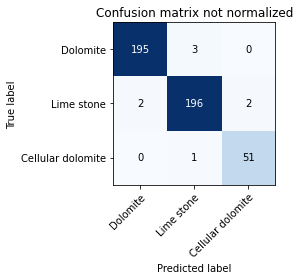

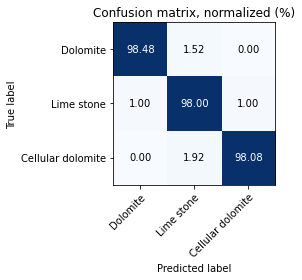

In [120]:
np.set_printoptions(precision=2)
df = df_results[np.isclose(df_results.Mixup,0)]
plot_confusion_matrix(df.predictions, df.actuals, classes=class_names,
                      title='Confusion matrix not normalized')
plot_confusion_matrix(df.predictions, df.actuals, classes=class_names, normalize=True,
                      title='Confusion matrix, normalized (%)')
plt.show()

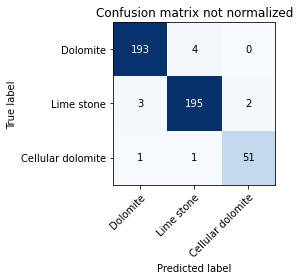

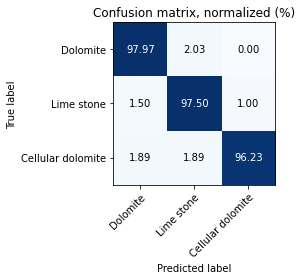

In [121]:
df = df_results[np.isclose(df_results.Mixup,0.25)]
plot_confusion_matrix(df.predictions, df.actuals, classes=class_names,
                      title='Confusion matrix not normalized')
plot_confusion_matrix(df.predictions, df.actuals, classes=class_names, normalize=True,
                      title='Confusion matrix, normalized (%)')
plt.show()

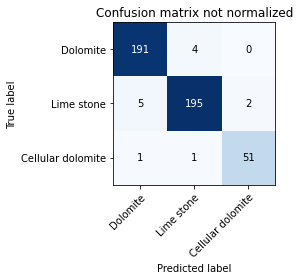

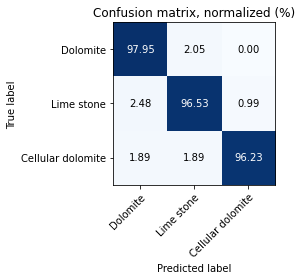

In [122]:
df = df_results[np.isclose(df_results.Mixup,0.5)]
plot_confusion_matrix(df.predictions, df.actuals, classes=class_names,
                      title='Confusion matrix not normalized')
plot_confusion_matrix(df.predictions, df.actuals, classes=class_names, normalize=True,
                      title='Confusion matrix, normalized (%)')
plt.show()